**Problem statement**: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### Necessary actions to read the data

### Importing all the important libraries

In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tf_keras
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.python.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.layers import Rescaling
from keras._tf_keras.keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras.utils import to_categorical
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from glob import glob
from tensorflow.keras.models import Model

In [ ]:
# Mount the google drive:

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Unzip all the images from assignment zip file
!unzip gdrive/MyDrive/CNN_assignment.zip

Archive:  gdrive/MyDrive/CNN_assignment.zip
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010889.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024468.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024470.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024511.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024646.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024654.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024707.jpg  
  inflating: Skin ca

**Summary of dataset:**

The dataset consists of 2357 images of malignant and benign oncological diseases, which were formed from the International Skin Imaging Collaboration (ISIC). All images were sorted according to the classification taken with ISIC, and all subsets were divided into the same number of images, with the exception of melanomas and moles, whose images are slightly dominant

The data set contains the following diseases:
- Actinic keratosis
- Basal cell carcinoma
- Dermatofibroma
- Melanoma
- Nevus
- Pigmented benign keratosis
- Seborrheic keratosis
- Squamous cell carcinoma
- Vascular lesion





In [ ]:
# Defining the path for train and test images
data_dir_train = pathlib.Path('Skin cancer ISIC The International Skin Imaging Collaboration/Train')
data_dir_test =  pathlib.Path('Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [ ]:
image_train = len(list(data_dir_train.glob('*/*.jpg')))
image_test = len(list(data_dir_test.glob('*/*.jpg')))

print(image_train)
print(image_test)
# Total Train + Test images : 2239 + 118 : 2357

2239
118


###  keras.preprocessing

We are loading the images from disk using image_dataset_from_directory utility.

### Create a dataset

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [ ]:
# Preparing training dataset
# Resize img_height*img_width as part of train dataset
# Using 80% of the images for training dataset.
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'training',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [ ]:
# Preparing validation dataset
# Resize img_height*img_width as part of train dataset
# Using 20% of the images for validation dataset.
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split=0.2,
  subset="validation",
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [ ]:
# Preparing test dataset
# Resize img_height*img_width as part of train dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test,
    seed=123,
    batch_size=118,
    image_size=(img_height,img_width)
)

Found 118 files belonging to 9 classes.


In [ ]:
# Finding all the class names in the class_names attribute on these datasets
class_names = train_ds.class_names
print(class_names)


['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Visualization of one instance of all the nine classes present in the dataset

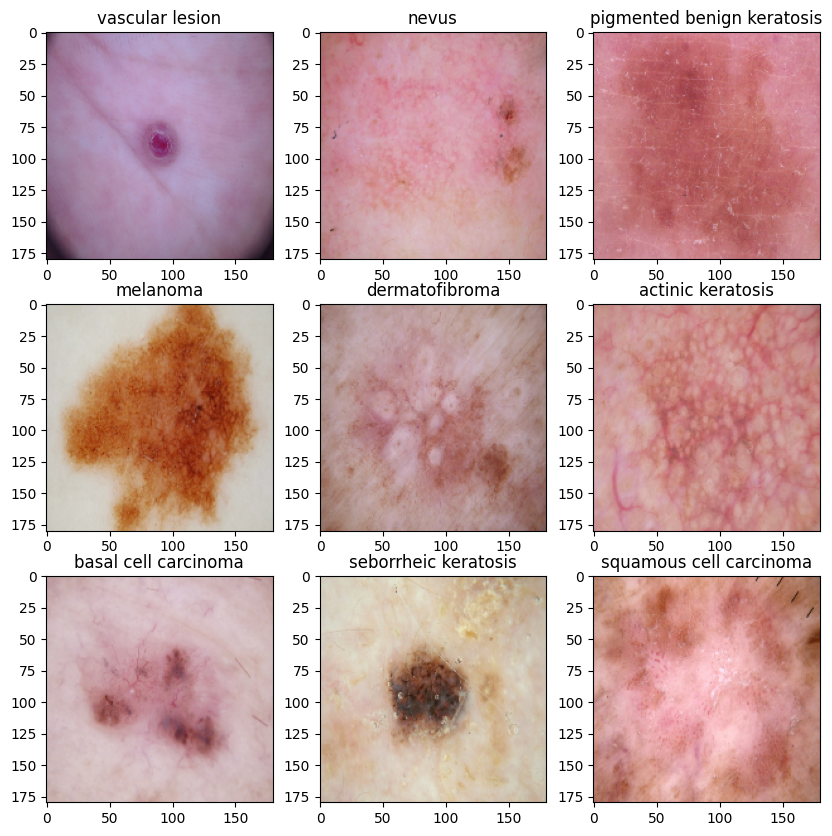

In [ ]:
plot_idx=0
visited={}
visited_all=False
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(50):
  if not visited_all:
    for i in range(9):

      if len(visited.keys())==9:
        visited_all=True
        break
      if class_names[labels[i]] in visited.keys():
        continue
      else:
        plt.subplot(3,3,plot_idx+1)
        plt.imshow(images[i].numpy().astype("uint8"));
        plt.title(class_names[labels[i]])
        visited[class_names[labels[i]]]="Y"
        plot_idx+=1
  else:
    break

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Train the model
#### We are creating a CNN model to accurately detect 9 classes present in the dataset.

In [ ]:
# Train a simple model using the datasets
num_classes = 9
model = tf_keras.Sequential([
                    tf_keras.layers.Rescaling(1./255, input_shape=(img_height, img_width,3)),
                    Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation= 'relu'),
                    MaxPool2D(pool_size = (2, 2)),
                    Dropout(0.25),
                    Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'),
                    MaxPool2D(pool_size = (2, 2)),
                    Dropout(0.25),
                    Flatten(),
                    Dense(128,activation='relu'),
                    Dense(len(class_names))
])

### Compile the model

### Choose the tf.keras.optimizers.Adam optimizer and tf.keras.losses.SparseCategoricalCrossentropy loss function. To view training and validation accuracy for each training epoch, pass the metrics argument to Model.compile.

In [ ]:
# Choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 module_wrapper (ModuleWrap  (None, 180, 180, 64)      1792      
 per)                                                            
                                                                 
 module_wrapper_1 (ModuleWr  (None, 90, 90, 64)        0         
 apper)                                                          
                                                                 
 module_wrapper_2 (ModuleWr  (None, 90, 90, 64)        0         
 apper)                                                          
                                                                 
 module_wrapper_3 (ModuleWr  (None, 90, 90, 64)        36928     
 apper)                                                 

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 25s 176ms/step - loss: 3.0037 - accuracy: 0.1456 - val_loss: 2.0619 - val_accuracy: 0.2058
Epoch 2/20
56/56 [==============================] - 5s 83ms/step - loss: 2.0455 - accuracy: 0.1964 - val_loss: 2.1172 - val_accuracy: 0.2058
Epoch 3/20
56/56 [==============================] - 5s 83ms/step - loss: 2.0189 - accuracy: 0.1998 - val_loss: 2.0271 - val_accuracy: 0.3244
Epoch 4/20
56/56 [==============================] - 5s 85ms/step - loss: 1.9110 - accuracy: 0.2907 - val_loss: 1.8492 - val_accuracy: 0.3378
Epoch 5/20
56/56 [==============================] - 5s 84ms/step - loss: 1.7515 - accuracy: 0.3873 - val_loss: 1.8198 - val_accuracy: 0.3915
Epoch 6/20
56/56 [==============================] - 5s 87ms/step - loss: 1.6429 - accuracy: 0.4224 - val_loss: 1.6201 - val_accuracy: 0.4586
Epoch 7/20
56/56 [==============================] - 5s 85ms/step - loss: 1.4650 - accuracy: 0.4888 - val_loss: 1.5235 - val_accuracy: 0.5123
Epoch 8/20


### Visualizing training results

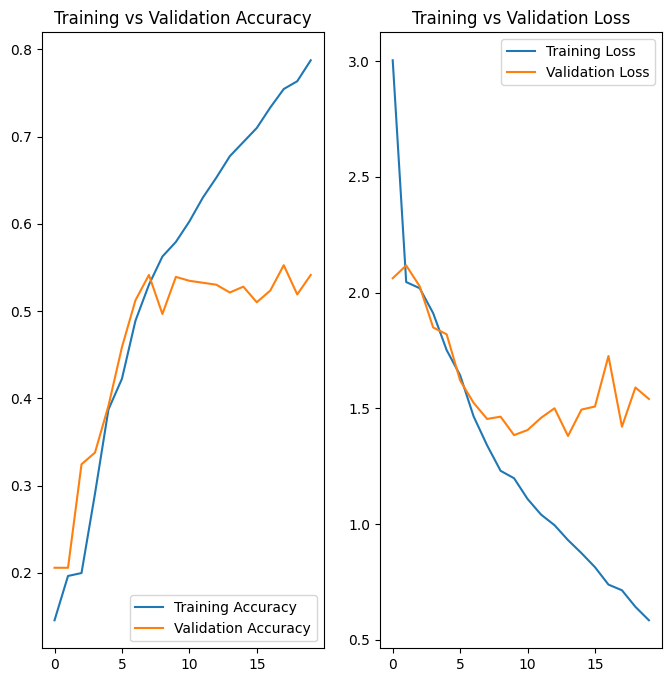

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training vs Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training vs Validation Loss')
plt.show()

In [ ]:
y_true=[]
y_pred=[]
for images, labels in test_ds.take(1):
  y_true=list(labels.numpy())
  y_pred=np.argmax(model.predict(images), axis=-1)

print(classification_report(y_true,y_pred,target_names=class_names))
print("*"*20)
print("Accuracy on test dataset : ",accuracy_score(y_true,y_pred))

4/4 [==============================] - 0s 78ms/step
                            precision    recall  f1-score   support

         actinic keratosis       0.67      0.12      0.21        16
      basal cell carcinoma       0.26      0.31      0.29        16
            dermatofibroma       0.00      0.00      0.00        16
                  melanoma       0.22      0.25      0.24        16
                     nevus       0.26      0.56      0.36        16
pigmented benign keratosis       0.38      0.75      0.50        16
      seborrheic keratosis       0.00      0.00      0.00         3
   squamous cell carcinoma       0.29      0.12      0.17        16
           vascular lesion       0.67      0.67      0.67         3

                  accuracy                           0.31       118
                 macro avg       0.30      0.31      0.27       118
              weighted avg       0.30      0.31      0.26       118

********************
Accuracy on test dataset :  0.3050847457

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


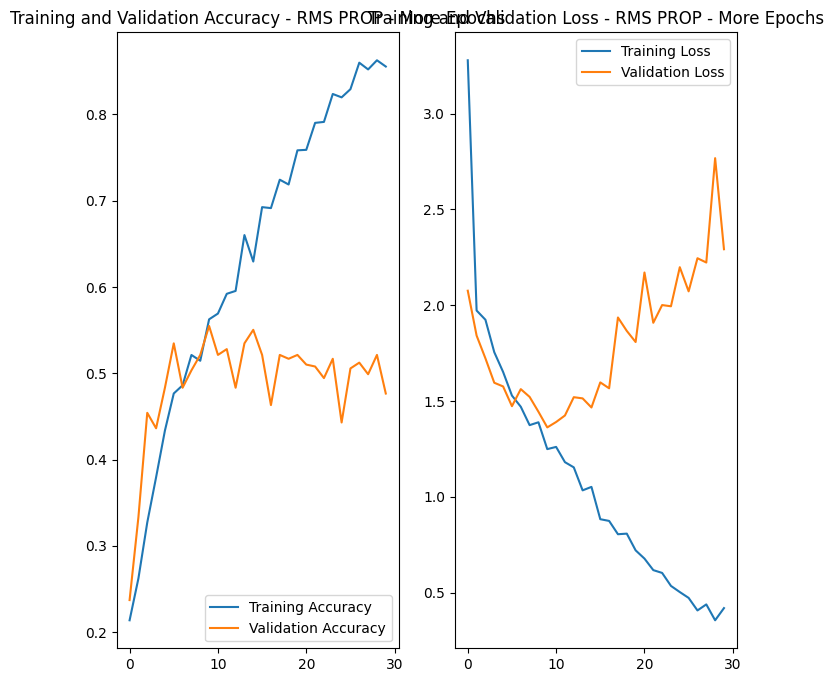

In [ ]:
#we visualize the results for the model

acc = history_rmsprop.history['accuracy']
val_acc = history_rmsprop.history['val_accuracy']

loss = history_rmsprop.history['loss']
val_loss = history_rmsprop.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy - RMS PROP - More Epochs')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss - RMS PROP - More Epochs')
plt.show()

In [ ]:
y_true=[]
y_pred=[]
for images, labels in test_ds.take(1):
  y_true=list(labels.numpy())
  y_pred=np.argmax(model_rmsprop.predict(images), axis=-1)
print(classification_report(y_true,y_pred,target_names=class_names))
print("*"*20)
print("RMS prop Accuracy on test dataset : ",accuracy_score(y_true,y_pred))

4/4 [==============================] - 3s 685ms/step
                            precision    recall  f1-score   support

         actinic keratosis       1.00      0.06      0.12        16
      basal cell carcinoma       0.33      0.25      0.29        16
            dermatofibroma       0.20      0.06      0.10        16
                  melanoma       0.22      0.25      0.24        16
                     nevus       0.19      0.38      0.25        16
pigmented benign keratosis       0.33      0.75      0.46        16
      seborrheic keratosis       0.00      0.00      0.00         3
   squamous cell carcinoma       0.30      0.19      0.23        16
           vascular lesion       0.50      0.67      0.57         3

                  accuracy                           0.28       118
                 macro avg       0.34      0.29      0.25       118
              weighted avg       0.36      0.28      0.24       118

********************
RMS prop Accuracy on test dataset :  0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Same model with more epochs and different opitmizer

num_classes = 9

model_rmsprop = tf_keras.Sequential([
                    tf_keras.layers.Rescaling(1./255, input_shape=(img_height, img_width,3)),
                    Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation= 'relu'),
                    MaxPool2D(pool_size = (2, 2)),
                    Dropout(0.25),
                    Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'),
                    MaxPool2D(pool_size = (2, 2)),
                    Dropout(0.25),
                    Flatten(),
                    Dense(128,activation='relu'),
                    Dense(len(class_names))
])

model_rmsprop.compile(optimizer='rmsprop',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])



In [ ]:
epochs = 30
history_rmsprop = model_rmsprop.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
56/56 [==============================] - 6s 88ms/step - loss: 3.0226 - accuracy: 0.2277 - val_loss: 1.9895 - val_accuracy: 0.2103
Epoch 2/30
56/56 [==============================] - 5s 84ms/step - loss: 1.9367 - accuracy: 0.2919 - val_loss: 1.8715 - val_accuracy: 0.3490
Epoch 3/30
56/56 [==============================] - 5s 83ms/step - loss: 1.7664 - accuracy: 0.3873 - val_loss: 1.8309 - val_accuracy: 0.3512
Epoch 4/30
56/56 [==============================] - 5s 85ms/step - loss: 1.6809 - accuracy: 0.4040 - val_loss: 1.5955 - val_accuracy: 0.4653
Epoch 5/30
56/56 [==============================] - 5s 82ms/step - loss: 1.5850 - accuracy: 0.4598 - val_loss: 1.5843 - val_accuracy: 0.4362
Epoch 6/30
56/56 [==============================] - 5s 84ms/step - loss: 1.4986 - accuracy: 0.4710 - val_loss: 1.5462 - val_accuracy: 0.4609
Epoch 7/30
56/56 [==============================] - 5s 84ms/step - loss: 1.4098 - accuracy: 0.5123 - val_loss: 1.4265 - val_accuracy: 0.5235
Epoch 8/30
56

#### Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Observations:
#### Have trained the same model with different optimizers (adams , rmsprop) and epochs(20 ,30).
1. 6-7 epochs  training and validation accuracy both increase .
2. After that training accuracy keeps on increasing to 80% whereas validation accuracy keeps fluctuating at 50% . Which means has begun to overfit.

In [ ]:
# After you have analysed the model fit history for presence of underfit or overfit,
# choose an appropriate data augumentation strategy.

data_aug = tf_keras.Sequential([
                             tf_keras.layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
                             tf_keras.layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
                             tf_keras.layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')
])

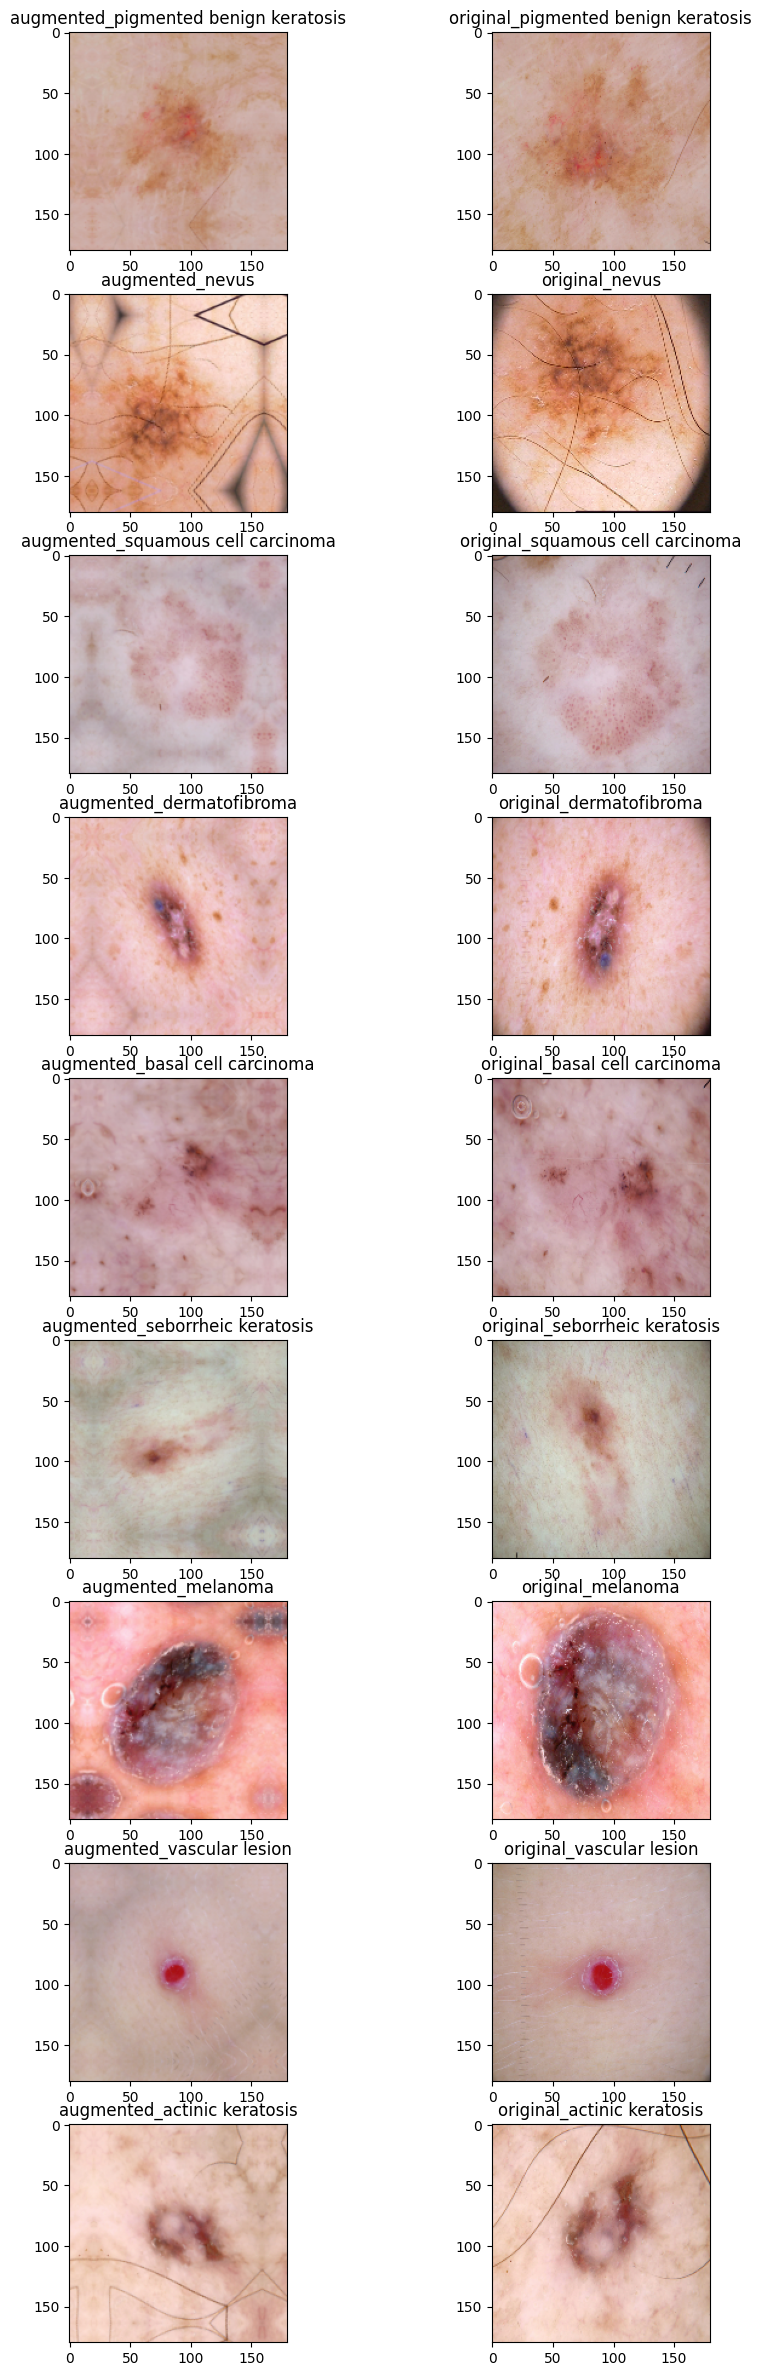

In [ ]:
# Visualize how the augmentation strategy works for one instance of training image.
plot_idx=0
visited={}
visited_all=False
plt.figure(figsize=(10,30))
for images, labels in train_ds.take(50):
  if not visited_all:
    for i in range(9):
      if len(visited.keys())==9:
        visited_all=True
        break
      if class_names[labels[i]] in visited.keys():
        continue
      else:
        plt.subplot(9,2,plot_idx+1)
        x=data_aug(images)
        plt.imshow(x[i].numpy().astype("uint8"));
        plt.title("augmented_"+class_names[labels[i]])
        plot_idx+=1
        plt.subplot(9,2,plot_idx+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title("original_"+class_names[labels[i]])
        visited[class_names[labels[i]]]="Y"
        plot_idx+=1

  else:
    break

### Create the model

In [24]:
# Use Dropout layer if there is an evidence of overfitting in your findings
model = tf_keras.Sequential([
                    data_aug,
                    tf_keras.layers.Rescaling(1./255, input_shape=(img_height, img_width,3)),
                    Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation= 'relu'),
                    MaxPool2D(pool_size = (2, 2)),
                    Dropout(0.25),
                    Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'),
                    MaxPool2D(pool_size = (2, 2)),
                    Dropout(0.25),
                    Flatten(),
                    Dense(128,activation='relu'),
                    Dense(len(class_names))
])

### Compiling the model

In [25]:
model.summary()
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 module_wrapper_18 (ModuleW  (None, 180, 180, 64)      1792      
 rapper)                                                         
                                                                 
 module_wrapper_19 (ModuleW  (None, 90, 90, 64)        0         
 rapper)                                                         
                                                                 
 module_wrapper_20 (ModuleW  (None, 90, 90, 64)        0         
 rapper)                                                         
                                                      

### Training the model

In [26]:
# Train the model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 7s 86ms/step - loss: 3.5028 - accuracy: 0.1791 - val_loss: 2.1716 - val_accuracy: 0.0962
Epoch 2/20
56/56 [==============================] - 5s 84ms/step - loss: 2.0286 - accuracy: 0.1953 - val_loss: 2.0183 - val_accuracy: 0.2282
Epoch 3/20
56/56 [==============================] - 5s 84ms/step - loss: 2.0132 - accuracy: 0.2115 - val_loss: 2.1117 - val_accuracy: 0.2506
Epoch 4/20
56/56 [==============================] - 5s 83ms/step - loss: 1.9895 - accuracy: 0.2377 - val_loss: 1.9970 - val_accuracy: 0.2349
Epoch 5/20
56/56 [==============================] - 5s 87ms/step - loss: 1.9389 - accuracy: 0.2812 - val_loss: 1.9505 - val_accuracy: 0.2796
Epoch 6/20
56/56 [==============================] - 5s 83ms/step - loss: 1.7482 - accuracy: 0.3588 - val_loss: 1.8008 - val_accuracy: 0.3512
Epoch 7/20
56/56 [==============================] - 5s 83ms/step - loss: 1.6591 - accuracy: 0.4046 - val_loss: 1.6743 - val_accuracy: 0.4116
Epoch 8/20
56

## Visualizing the results

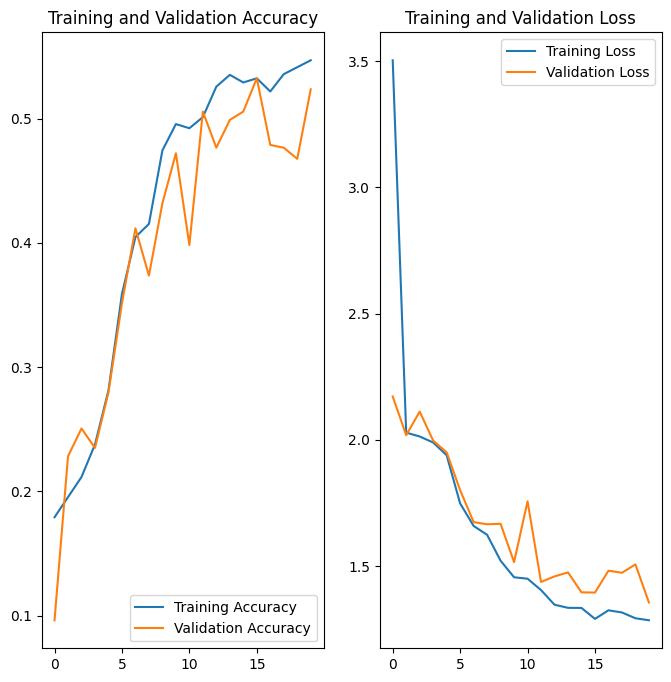

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [28]:
# Use of different optimizer
model_aug_adagrad = tf_keras.Sequential([
                    data_aug,
                    tf_keras.layers.Rescaling(1./255, input_shape=(img_height, img_width,3)),
                    Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation= 'relu'),
                    MaxPool2D(pool_size = (2, 2)),
                    Dropout(0.25),
                    Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'),
                    MaxPool2D(pool_size = (2, 2)),
                    Dropout(0.25),
                    Flatten(),
                    Dense(128,activation='relu'),
                    Dense(len(class_names))
])

model_aug_adagrad.compile(optimizer='adagrad',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])



In [29]:
epochs = 20
history_aug_adagrad = model_aug_adagrad.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 8s 88ms/step - loss: 2.0532 - accuracy: 0.2020 - val_loss: 2.0393 - val_accuracy: 0.2058
Epoch 2/20
56/56 [==============================] - 5s 88ms/step - loss: 2.0255 - accuracy: 0.2154 - val_loss: 2.0437 - val_accuracy: 0.2058
Epoch 3/20
56/56 [==============================] - 5s 86ms/step - loss: 2.0182 - accuracy: 0.2199 - val_loss: 2.0621 - val_accuracy: 0.1924
Epoch 4/20
56/56 [==============================] - 5s 90ms/step - loss: 2.0061 - accuracy: 0.2372 - val_loss: 2.0157 - val_accuracy: 0.2573
Epoch 5/20
56/56 [==============================] - 5s 87ms/step - loss: 1.9852 - accuracy: 0.2528 - val_loss: 2.0115 - val_accuracy: 0.2595
Epoch 6/20
56/56 [==============================] - 5s 86ms/step - loss: 1.9720 - accuracy: 0.2723 - val_loss: 2.0061 - val_accuracy: 0.2886
Epoch 7/20
56/56 [==============================] - 5s 89ms/step - loss: 1.9492 - accuracy: 0.2935 - val_loss: 1.9623 - val_accuracy: 0.3579
Epoch 8/20
56

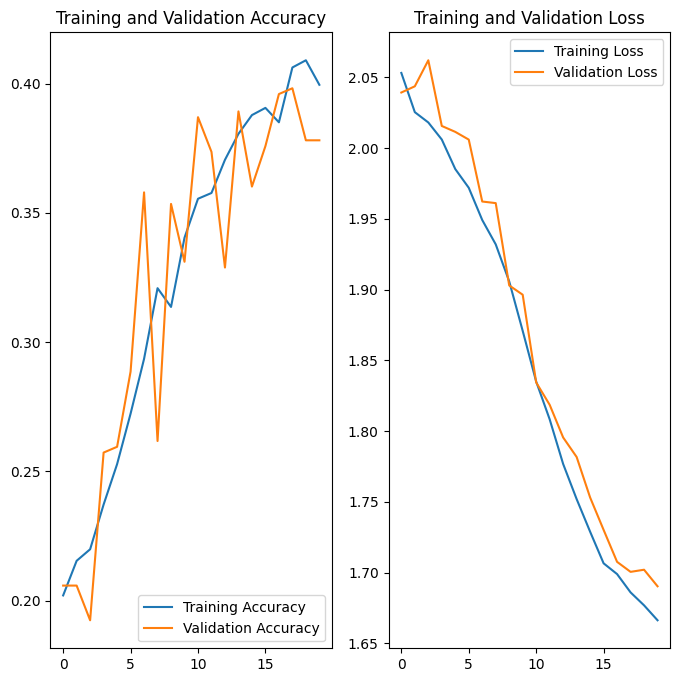

In [31]:
#Performance visualisation for adagrad optimiser
acc = history_aug_adagrad.history['accuracy']
val_acc = history_aug_adagrad.history['val_accuracy']

loss = history_aug_adagrad.history['loss']
val_loss = history_aug_adagrad.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [33]:
# Create another model with SGD opitmizer
model_aug_sgd = tf_keras.Sequential([
                    data_aug,
                    tf_keras.layers.Rescaling(1./255, input_shape=(img_height, img_width,3)),
                    Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation= 'relu'),
                    MaxPool2D(pool_size = (2, 2)),
                    Dropout(0.25),
                    Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'),
                    MaxPool2D(pool_size = (2, 2)),
                    Dropout(0.25),
                    Flatten(),
                    Dense(128,activation='relu'),
                    Dense(len(class_names))
])

model_aug_sgd.compile(optimizer='sgd',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [34]:
epochs = 20
history_aug_sgd = model_aug_sgd.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 6s 89ms/step - loss: 2.0542 - accuracy: 0.1897 - val_loss: 2.0600 - val_accuracy: 0.2058
Epoch 2/20
56/56 [==============================] - 5s 85ms/step - loss: 2.0147 - accuracy: 0.2416 - val_loss: 2.0349 - val_accuracy: 0.2282
Epoch 3/20
56/56 [==============================] - 5s 89ms/step - loss: 1.9965 - accuracy: 0.2561 - val_loss: 2.0075 - val_accuracy: 0.2819
Epoch 4/20
56/56 [==============================] - 5s 87ms/step - loss: 1.9746 - accuracy: 0.2695 - val_loss: 1.9942 - val_accuracy: 0.3624
Epoch 5/20
56/56 [==============================] - 5s 86ms/step - loss: 1.9317 - accuracy: 0.2907 - val_loss: 1.8831 - val_accuracy: 0.3669
Epoch 6/20
56/56 [==============================] - 5s 87ms/step - loss: 1.9079 - accuracy: 0.2935 - val_loss: 1.8540 - val_accuracy: 0.3557
Epoch 7/20
56/56 [==============================] - 5s 86ms/step - loss: 1.8692 - accuracy: 0.3287 - val_loss: 1.8032 - val_accuracy: 0.3669
Epoch 8/20
56

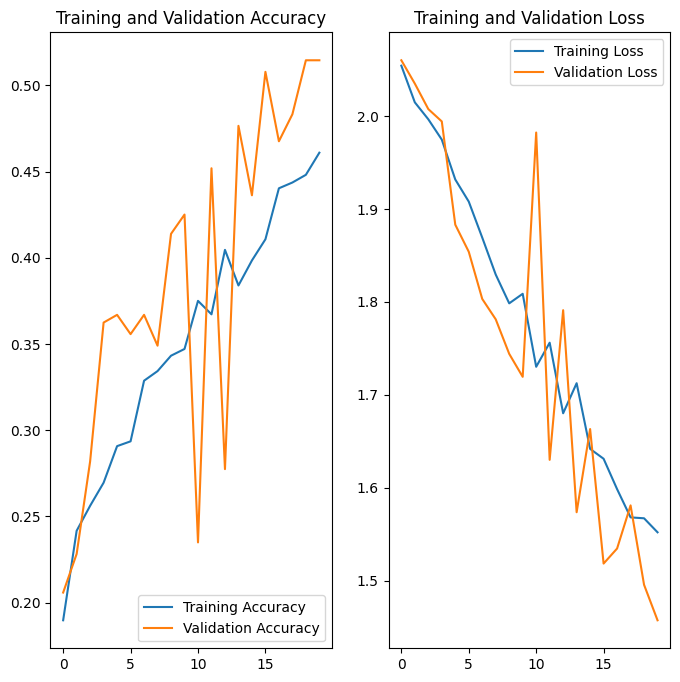

In [35]:
# We create performance visualisation for sgd optimizer
acc = history_aug_sgd.history['accuracy']
val_acc = history_aug_sgd.history['val_accuracy']

loss = history_aug_sgd.history['loss']
val_loss = history_aug_sgd.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [36]:
# Check the performance on the test set
y_true=[]
y_pred=[]
for images, labels in test_ds.take(1):
  y_true=list(labels.numpy())

  y_pred=np.argmax(model.predict(images), axis=-1)

  print("Adam optimizer")
  print(classification_report(y_true,y_pred,target_names=class_names))
  print("Accuracy on test dataset : ",accuracy_score(y_true,y_pred))
  print("*"*20)

  y_pred=np.argmax(model_aug_adagrad.predict(images), axis=-1)

  print("Adagrad optimizer")
  print(classification_report(y_true,y_pred,target_names=class_names))
  print("Accuracy on test dataset : ",accuracy_score(y_true,y_pred))
  print("*"*20)

  y_pred=np.argmax(model_aug_sgd.predict(images), axis=-1)

  print("SGD optimizer")
  print(classification_report(y_true,y_pred,target_names=class_names))
  print("Accuracy on test dataset : ",accuracy_score(y_true,y_pred))
  print("*"*20)

4/4 [==============================] - 0s 13ms/step
Adam optimizer
                            precision    recall  f1-score   support

         actinic keratosis       0.00      0.00      0.00        16
      basal cell carcinoma       0.34      0.69      0.46        16
            dermatofibroma       0.00      0.00      0.00        16
                  melanoma       0.27      0.38      0.32        16
                     nevus       0.54      0.81      0.65        16
pigmented benign keratosis       0.35      0.69      0.47        16
      seborrheic keratosis       0.00      0.00      0.00         3
   squamous cell carcinoma       0.33      0.12      0.18        16
           vascular lesion       0.67      0.67      0.67         3

                  accuracy                           0.38       118
                 macro avg       0.28      0.37      0.30       118
              weighted avg       0.27      0.38      0.30       118

Accuracy on test dataset :  0.3813559322033898

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

4/4 [==============================] - 0s 13ms/step
SGD optimizer
                            precision    recall  f1-score   support

         actinic keratosis       1.00      0.12      0.22        16
      basal cell carcinoma       0.45      0.62      0.53        16
            dermatofibroma       0.00      0.00      0.00        16
                  melanoma       0.11      0.12      0.11        16
                     nevus       0.65      0.94      0.77        16
pigmented benign keratosis       0.27      0.81      0.40        16
      seborrheic keratosis       0.00      0.00      0.00         3
   squamous cell carcinoma       0.00      0.00      0.00        16
           vascular lesion       0.67      0.67      0.67         3

                  accuracy                           0.37       118
                 macro avg       0.35      0.37      0.30       118
              weighted avg       0.35      0.37      0.29       118

Accuracy on test dataset :  0.3728813559322034


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

#### <u>Observations</u> <b>We observed that after addition of Agumentation layers, we were able to reduce the model's overfitting. However in this case the model is not able to generalise well. We tried out different set of optmizers sgd,adagrad,adams which gave models that had low Training and Validation accuracy.The accuracy figures were between 45-55% both for training and validation .But now the model has begun to overfit.</b>

####Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [37]:
train_path_list = list(data_dir_train.glob('*/*.jpg'))

In [38]:
df=pd.DataFrame({"cancer_type":[str(x).split("/")[2] for x in train_path_list]})

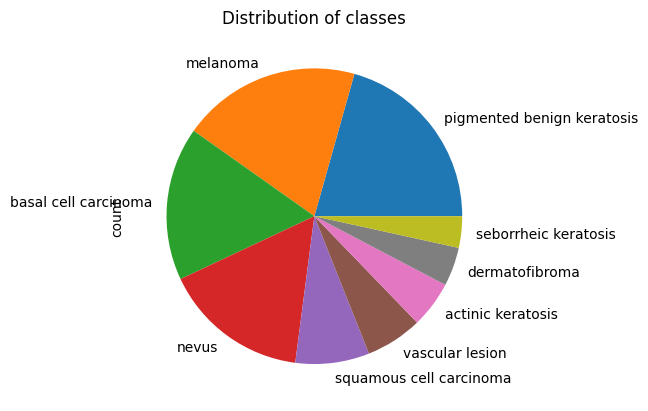

In [39]:
# We look at the distribution of classes
df['cancer_type'].value_counts().plot(kind='pie')
plt.title("Distribution of classes")
plt.show()

#### Write your findings here:
#### - Which class has the least number of samples?
#### **Ans : seborrheic keratosis**
#### - Which classes dominate the data in terms proportionate number of samples?
#### <b>Ans : pigmented benign keratosis</b>

#### Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [40]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.

In [41]:
path_to_training_dataset="Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)

Initialised with 114 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7DFAF837C940>: 100%|██████████| 500/500 [00:19<00:00, 25.47 Samples/s]


Initialised with 376 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7DFB6AF611E0>: 100%|██████████| 500/500 [00:19<00:00, 25.98 Samples/s]


Initialised with 95 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7DFB7D769030>: 100%|██████████| 500/500 [00:19<00:00, 25.10 Samples/s]


Initialised with 438 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=3072x2304 at 0x7DFB7D7D7C40>: 100%|██████████| 500/500 [01:21<00:00,  6.15 Samples/s]


Initialised with 357 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=767x576 at 0x7DFB0D3F25C0>: 100%|██████████| 500/500 [01:13<00:00,  6.82 Samples/s]


Initialised with 462 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7DFB7C4C29E0>: 100%|██████████| 500/500 [00:14<00:00, 33.51 Samples/s]


Initialised with 77 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7DFB7D769030>: 100%|██████████| 500/500 [00:34<00:00, 14.34 Samples/s]


Initialised with 181 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7DFB0D3C73D0>: 100%|██████████| 500/500 [00:14<00:00, 34.57 Samples/s]


Initialised with 139 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7DFB7BEDE380>: 100%|██████████| 500/500 [00:14<00:00, 33.78 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.Let's validate the total count of augmented images.

In [42]:
image_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [43]:
# path list
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [44]:
# lesion list
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]


In [45]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [46]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])

In [47]:
#Created 500 samples for each
df2['Label'].value_counts()

Label
pigmented benign keratosis    500
vascular lesion               500
seborrheic keratosis          500
basal cell carcinoma          500
dermatofibroma                500
melanoma                      500
nevus                         500
squamous cell carcinoma       500
actinic keratosis             500
Name: count, dtype: int64

In [48]:
#Check the new counts
new_list=list(df['cancer_type'].values)
new_list.extend(list(df2['Label'].values))
len(new_list)
final_df=pd.DataFrame({"cancer_type":new_list})
final_df['cancer_type'].value_counts()

cancer_type
pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: count, dtype: int64

Now, we have added 500 images to all the classes to maintain some class balance.

####Train the model on the data created using Augmentor

In [49]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [50]:
data_dir_train="Skin cancer ISIC The International Skin Imaging Collaboration/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


####Create a validation dataset

In [51]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


####Create your model (make sure to include normalization)

In [52]:
model = tf_keras.Sequential([
                    tf_keras.layers.Rescaling(1./255, input_shape=(img_height, img_width,3)),
                    Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation= 'relu'),
                    MaxPool2D(pool_size = (2, 2)),
                    Dropout(0.40),
                    Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'),
                     MaxPool2D(pool_size = (2, 2)),
                    Dropout(0.40),
                    Flatten(),
                    Dense(128,activation='relu'),
                    Dense(len(class_names))
])

####Compile your model (Choose optimizer and loss function appropriately)

In [53]:
model.summary()
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 module_wrapper_54 (ModuleW  (None, 180, 180, 64)      1792      
 rapper)                                                         
                                                                 
 module_wrapper_55 (ModuleW  (None, 90, 90, 64)        0         
 rapper)                                                         
                                                                 
 module_wrapper_56 (ModuleW  (None, 90, 90, 64)        0         
 rapper)                                                         
                                                                 
 module_wrapper_57 (ModuleW  (None, 90, 90, 64)        36928     
 rapper)                                              

In [54]:
# Training your model

In [55]:
epochs = 50
#using 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
169/169 [==============================] - 33s 190ms/step - loss: 2.6654 - accuracy: 0.2096 - val_loss: 2.0206 - val_accuracy: 0.2576
Epoch 2/50
169/169 [==============================] - 32s 191ms/step - loss: 1.7987 - accuracy: 0.3342 - val_loss: 1.7255 - val_accuracy: 0.3615
Epoch 3/50
169/169 [==============================] - 33s 196ms/step - loss: 1.5823 - accuracy: 0.3982 - val_loss: 1.5454 - val_accuracy: 0.3964
Epoch 4/50
169/169 [==============================] - 27s 161ms/step - loss: 1.3956 - accuracy: 0.4696 - val_loss: 1.4381 - val_accuracy: 0.4484
Epoch 5/50
169/169 [==============================] - 28s 168ms/step - loss: 1.2740 - accuracy: 0.5247 - val_loss: 1.2407 - val_accuracy: 0.5316
Epoch 6/50
169/169 [==============================] - 27s 160ms/step - loss: 1.1499 - accuracy: 0.5755 - val_loss: 1.2417 - val_accuracy: 0.5427
Epoch 7/50
169/169 [==============================] - 32s 188ms/step - loss: 1.0230 - accuracy: 0.6296 - val_loss: 1.0568 - val_ac

### Visualize the model results

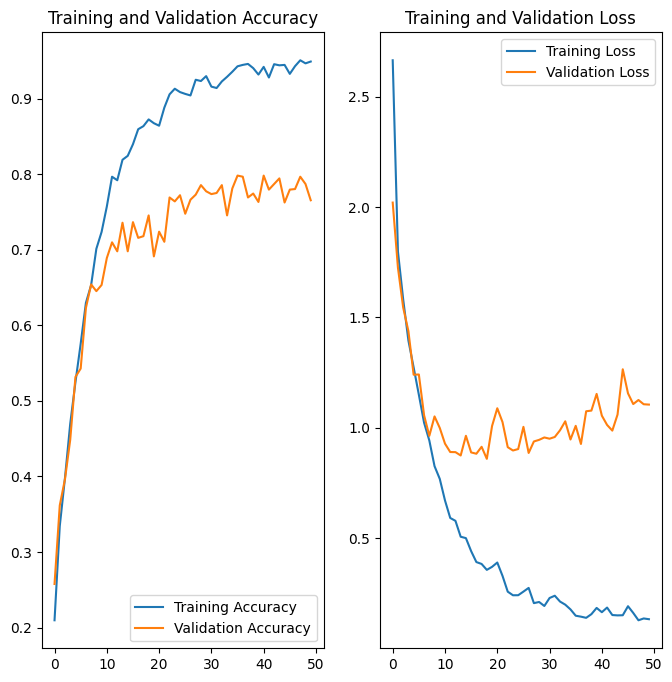

In [56]:
# Plot for ADAM optimizer
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# We try with a different model optimizer
model_imbalance_sgd = tf_keras.Sequential([
                    tf_keras.layers.Rescaling(1./255, input_shape=(img_height, img_width,3)),
                    Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation= 'relu'),
                    MaxPool2D(pool_size = (2, 2)),
                    Dropout(0.25),
                    Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'),
                    MaxPool2D(pool_size = (2, 2)),
                    Dropout(0.25),
                    Flatten(),
                    Dense(128,activation='relu'),
                    Dense(len(class_names))
])

model_imbalance_sgd.compile(optimizer='sgd',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

epochs = 30
history_imbalance_sgd = model_imbalance_sgd.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
56/56 [==============================] - 203s 4s/step - loss: 2.1130 - accuracy: 0.1903 - val_loss: 2.0590 - val_accuracy: 0.1790
Epoch 2/30
56/56 [==============================] - 211s 4s/step - loss: 2.0128 - accuracy: 0.2266 - val_loss: 2.0525 - val_accuracy: 0.2774
Epoch 3/30
56/56 [==============================] - 204s 4s/step - loss: 1.9859 - accuracy: 0.2690 - val_loss: 2.0309 - val_accuracy: 0.3602
Epoch 4/30
56/56 [==============================] - 203s 4s/step - loss: 1.9476 - accuracy: 0.2824 - val_loss: 2.0166 - val_accuracy: 0.2483
Epoch 5/30
56/56 [==============================] - 203s 4s/step - loss: 1.9065 - accuracy: 0.3030 - val_loss: 1.9146 - val_accuracy: 0.3356
Epoch 6/30
56/56 [==============================] - 206s 4s/step - loss: 1.8724 - accuracy: 0.3158 - val_loss: 1.8341 - val_accuracy: 0.3781
Epoch 7/30
56/56 [==============================] - 202s 4s/step - loss: 1.8167 - accuracy: 0.3304 - val_loss: 1.8426 - val_accuracy: 0.3356
Epoch 8/30
56

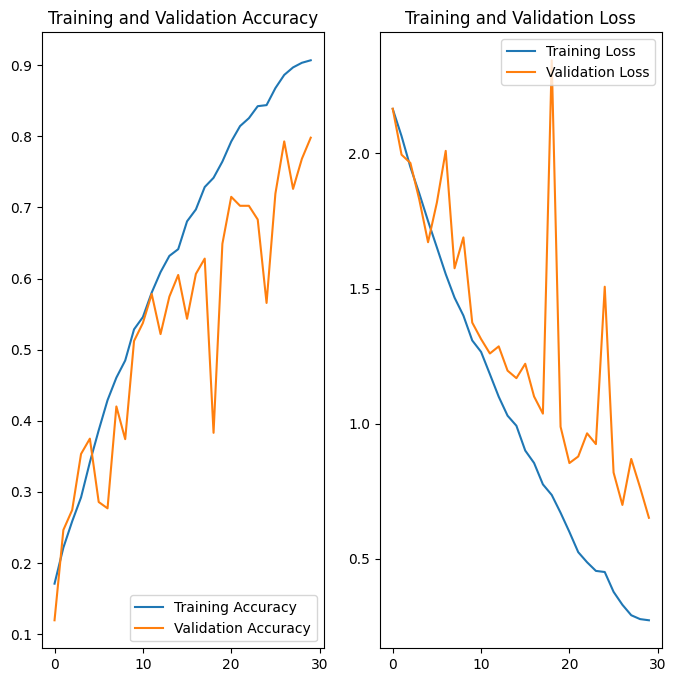

In [ ]:
# We plot for SGD optimizer
acc = history_imbalance_sgd.history['accuracy']
val_acc = history_imbalance_sgd.history['val_accuracy']

loss = history_imbalance_sgd.history['loss']
val_loss = history_imbalance_sgd.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
#trying with a different model
model_imbalance_adagrad = tf_keras.Sequential([
                    tf_keras.layers.Rescaling(1./255, input_shape=(img_height, img_width,3)),
                    Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation= 'relu'),
                    MaxPool2D(pool_size = (2, 2)),
                    Dropout(0.25),
                    Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'),
                    MaxPool2D(pool_size = (2, 2)),
                    Dropout(0.25),
                    Flatten(),
                    Dense(128,activation='relu'),
                    Dense(len(class_names))
])

model_imbalance_adagrad.compile(optimizer='adagrad',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

epochs = 30

history_imbalance_adagrad = model_imbalance_adagrad.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
56/56 [==============================] - 229s 4s/step - loss: 2.0487 - accuracy: 0.1925 - val_loss: 2.0573 - val_accuracy: 0.2260
Epoch 2/30
56/56 [==============================] - 207s 4s/step - loss: 2.0159 - accuracy: 0.2282 - val_loss: 2.0253 - val_accuracy: 0.2058
Epoch 3/30
56/56 [==============================] - 210s 4s/step - loss: 1.9999 - accuracy: 0.2472 - val_loss: 1.9947 - val_accuracy: 0.2461
Epoch 4/30
56/56 [==============================] - 216s 4s/step - loss: 1.9856 - accuracy: 0.2589 - val_loss: 1.9959 - val_accuracy: 0.2886
Epoch 5/30
56/56 [==============================] - 207s 4s/step - loss: 1.9572 - accuracy: 0.2935 - val_loss: 1.9760 - val_accuracy: 0.2953
Epoch 6/30
56/56 [==============================] - 215s 4s/step - loss: 1.9350 - accuracy: 0.3002 - val_loss: 1.9422 - val_accuracy: 0.3602
Epoch 7/30
56/56 [==============================] - 208s 4s/step - loss: 1.9076 - accuracy: 0.3181 - val_loss: 1.9134 - val_accuracy: 0.3535
Epoch 8/30
56

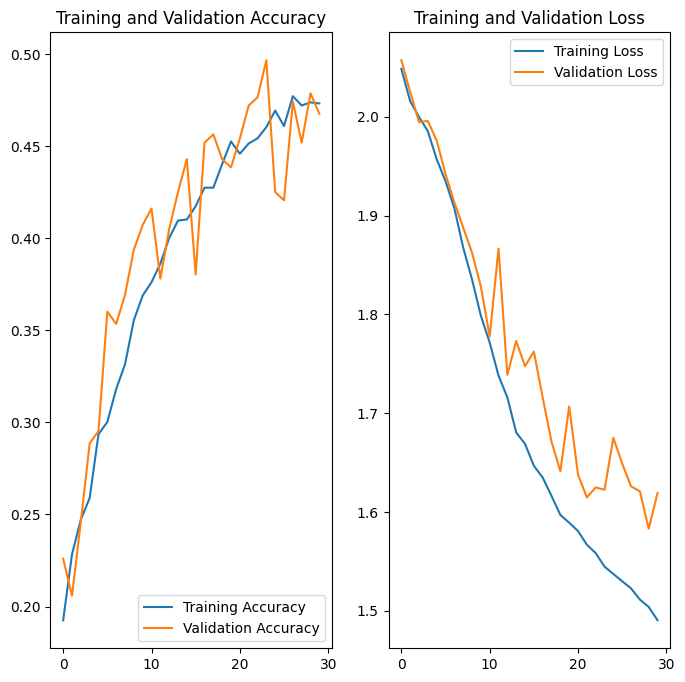

In [ ]:
# we visualize for adagrad
acc = history_imbalance_adagrad.history['accuracy']
val_acc = history_imbalance_adagrad.history['val_accuracy']

loss = history_imbalance_adagrad.history['loss']
val_loss = history_imbalance_adagrad.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

So we have tried the model with different epochs (30,50) and optimizers (adam, sgd , adaagrad) .  The initial model with adam optimizer with 50 epochs seems to work well with validation accuracy reaching about 80%.

In [ ]:
# We check the performance on the test set
y_true=[]
y_pred=[]
for images, labels in test_ds.take(1):

  y_true=list(labels.numpy())
  y_pred=np.argmax(model.predict(images), axis=-1)

  print("Adam optimizer")
  print(classification_report(y_true,y_pred,target_names=class_names))
  print("Accuracy on test dataset : ",accuracy_score(y_true,y_pred))
  print("*"*20)
  y_pred=np.argmax(model_imbalance_adagrad.predict(images), axis=-1)

  print("Adagrad optimizer")
  print(classification_report(y_true,y_pred,target_names=class_names))
  print("Accuracy on test dataset : ",accuracy_score(y_true,y_pred))
  print("*"*20)
  y_pred=np.argmax(model_imbalance_sgd.predict(images), axis=-1)

  print("SGD optimizer")
  print(classification_report(y_true,y_pred,target_names=class_names))
  print("Accuracy on test dataset : ",accuracy_score(y_true,y_pred))
  print("*"*20)

4/4 [==============================] - 4s 961ms/step
Adam optimizer
                            precision    recall  f1-score   support

         actinic keratosis       0.00      0.00      0.00        16
      basal cell carcinoma       0.00      0.00      0.00        16
            dermatofibroma       0.00      0.00      0.00        16
                  melanoma       0.00      0.00      0.00        16
                     nevus       1.00      0.06      0.12        16
pigmented benign keratosis       0.00      0.00      0.00        16
      seborrheic keratosis       0.03      0.67      0.05         3
   squamous cell carcinoma       0.00      0.00      0.00        16
           vascular lesion       0.00      0.00      0.00         3

                  accuracy                           0.03       118
                 macro avg       0.11      0.08      0.02       118
              weighted avg       0.14      0.03      0.02       118

Accuracy on test dataset :  0.025423728813559

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


4/4 [==============================] - 3s 654ms/step
Adagrad optimizer
                            precision    recall  f1-score   support

         actinic keratosis       0.00      0.00      0.00        16
      basal cell carcinoma       0.31      0.56      0.40        16
            dermatofibroma       0.00      0.00      0.00        16
                  melanoma       0.00      0.00      0.00        16
                     nevus       0.44      0.44      0.44        16
pigmented benign keratosis       0.24      0.75      0.36        16
      seborrheic keratosis       0.00      0.00      0.00         3
   squamous cell carcinoma       0.00      0.00      0.00        16
           vascular lesion       0.18      0.67      0.29         3

                  accuracy                           0.25       118
                 macro avg       0.13      0.27      0.16       118
              weighted avg       0.14      0.25      0.17       118

Accuracy on test dataset :  0.254237288135

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


4/4 [==============================] - 3s 642ms/step
SGD optimizer
                            precision    recall  f1-score   support

         actinic keratosis       0.00      0.00      0.00        16
      basal cell carcinoma       0.31      0.75      0.44        16
            dermatofibroma       0.00      0.00      0.00        16
                  melanoma       0.24      0.25      0.24        16
                     nevus       0.62      0.81      0.70        16
pigmented benign keratosis       0.33      0.56      0.42        16
      seborrheic keratosis       0.00      0.00      0.00         3
   squamous cell carcinoma       0.30      0.19      0.23        16
           vascular lesion       0.50      0.67      0.57         3

                  accuracy                           0.36       118
                 macro avg       0.26      0.36      0.29       118
              weighted avg       0.26      0.36      0.29       118

Accuracy on test dataset :  0.3644067796610169

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

<b>We tried different models with optimizers (sgd, adams, adagrad) and epochs (30,50,30) . By adding augmented images which inturn helped in handling class imbalance , we were able to address and mitigate the problem of overfitting . Out of all the models that we evaluated, the performance was decent for the model with Adam's optimizer . The model had a train accuracy of ~90% while the validation accuracy was about ~80% . This model learns rapidly (increase in training and validation accuracy)for the first 20 epochs , but after this the learning becomes slow </b>.